In [1]:
import sys
sys.path.append('/hdd/si_han/Tools/python_modules/')
sys.path.insert(1,'/hdd/si_han/cpptraj_test/pytraj') 

import pytraj as pt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolateCurve import interpolateCurve
from log_progress import*
from LineBuilder import*

In [2]:
## correct (Xp, Yp) and (Xn, Yn)
def CorrectXYnp(Xp,Yp,Xn,Yn):
    for i in range(1,len(slope_opt)):
        d1 = (Xp[i] - Xp[i-1])**2 + (Yp[i] - Yp[i-1])**2
        d2 = (Xn[i] - Xp[i-1])**2 + (Yn[i] - Yp[i-1])**2
        d3 = (Xn[i] - Xn[i-1])**2 + (Yn[i] - Yn[i-1])**2
        d4 = (Xp[i] - Xn[i-1])**2 + (Yp[i] - Yn[i-1])**2
#         if d1>d2:
        if max(d2,d4) < max(d1,d3):
            tmpx, tmpy = [Xp[i].copy(), Yp[i].copy()]
            tmpx1, tmpy1 = [Xn[i].copy(), Yn[i].copy()]
            Xp[i], Yp[i], Xn[i], Yn[i] = [tmpx1, tmpy1, tmpx, tmpy]

## Load metadynamics trajectories and generate PCs
Here we need to first obtain PCs, reaction path, and milestones we generated in Milestoning_Generate

In [5]:
# specify path of promtop and dcd files
reaction_path = '/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory'
TOP = reaction_path+'/complex.prmtop'
TRAJ = reaction_path+'/nowater.dcd'

# read the trajecory from the disk
traj = pt.iterload(TRAJ, TOP,stride=1)

# superpose to the reference of the original trajectory
refpdb = pt.load(reaction_path+'/0.pdb')
pt.superpose(traj, ref=refpdb, mask='(:1-359)&(@N,@C,@CA,@O)')

# read the trajectory into memory by chunk
nframe = traj.n_frames
chunksize = min([200, nframe])
nchunk = int(np.floor(nframe/chunksize))+1 if nframe%chunksize !=0 else int(np.floor(nframe/chunksize))
pile = []
for i in log_progress(range(nchunk), every=1):
    tmp = traj[i*chunksize:min((i+1)*chunksize, nframe)]['@CA,:620']['!@H*']
    pile.append(tmp.xyz.reshape(tmp.n_frames, tmp.n_atoms*3))
    
proteinUNK_2d = np.concatenate(pile,axis=0)
proteinUNK_2d = proteinUNK_2d - proteinUNK_2d.mean(axis=0)

# PCA using sklearn
pca = PCA(n_components=2)
reduced_cartesian = pca.fit_transform(proteinUNK_2d)
print(reduced_cartesian.shape)

# obtain eigvals and eigvecs
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_.T

(5455, 2)


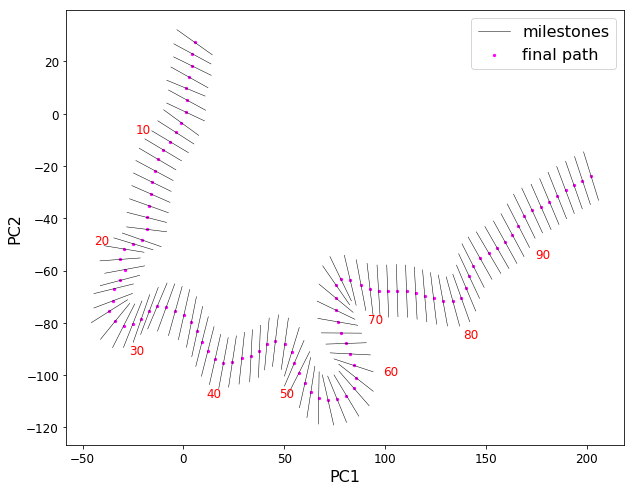

In [6]:
path_id = 0  # specify which path you want to write/load
milestone_path=reaction_path+'/Milestone_%d'%path_id

# load reaction path
path = pd.read_csv(milestone_path+'/finalpath.txt', header=None, delimiter=r"\s+")
fp = np.asarray(path)
fp = fp[:,1:3]
fp.shape

# load milestone slopes
slope_opt = np.load(milestone_path+'milestone_slopes.npy')

# length of milestone lines
sc = 20 

# coordinates of milestones on the path
X = fp[:,0].reshape(len(fp),1)
Y = fp[:,1].reshape(len(fp),1)

# slope matrix NxN
M = np.zeros((len(slope_opt),len(slope_opt)))
np.fill_diagonal(M,slope_opt)

# boundary of milestones in x-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_opt**2)).reshape(len(fp),1)
Xp = X + dX
Xn = X - dX

# boundary of milestones in y-axis Nx1
Yp = Y + np.dot(M,dX)
Yn = Y - np.dot(M,dX)
CorrectXYnp(Xp,Yp,Xn,Yn)

# plot milestones
plt.figure(figsize=(10,8))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

## Projecting metadynamics trajectories onto the PC1/PC2 space

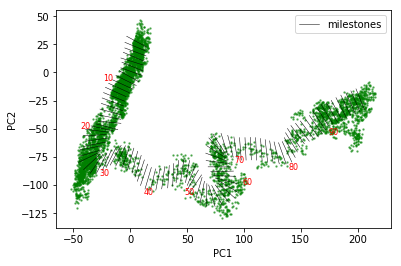

In [7]:
# set the first frame of the trajectory as an origin
refframe =  proteinUNK_2d[0,:].copy()
proteinUNK_ref_2d = proteinUNK_2d - refframe

# project high-d Cartesian coordinates into low-d PCs
projections=np.concatenate((np.dot(proteinUNK_ref_2d, eigvecs[:,0]).reshape(len(proteinUNK_ref_2d),1),
                            np.dot(proteinUNK_ref_2d, eigvecs[:,1]).reshape(len(proteinUNK_ref_2d),1)),
                           axis=1)

# plot results
plt.figure()
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 2,
        c='green',
        alpha=0.5
        )
plt.xlabel('PC1')
plt.ylabel('PC2')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=8, color='r'))
plt.legend()

plt.show()

## Color the projected trajectories by milestone cells

In [9]:
def area(x1,y1,x2,y2,x3,y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)

x1,y1=[Xp[:-1],Yp[:-1]]
x2,y2=[Xn[:-1],Yn[:-1]]
x3,y3=[Xp[1:],Yp[1:]]
A1 = area(x1,y1,x2,y2,x3,y3)
x1,y1=[Xn[1:],Yn[1:]]
x2,y2=[Xn[:-1],Yn[:-1]]
x3,y3=[Xp[1:],Yp[1:]]
A2 = area(x1,y1,x2,y2,x3,y3)
Acell = A1+A2

### Index each projected frames by milestone cells

In [10]:
midx=np.empty(len(projections))
midx.fill(2*len(fp))
    
for i in log_progress(range(len(Xp)-1)):
    x1,y1=[Xp[i],Yp[i]]
    x2,y2=[Xn[i],Yn[i]]
    x3,y3=[Xn[i+1],Yn[i+1]]
    x4,y4=[Xp[i+1],Yp[i+1]]
    x,y=[projections[:,0], projections[:,1]]
    a1 = area(x,y,x1,y1,x2,y2)
    a2 = area(x,y,x2,y2,x3,y3)
    a3 = area(x,y,x3,y3,x4,y4)
    a4 = area(x,y,x4,y4,x1,y1)
    A = a1+a2+a3+a4
    index = abs(A-Acell[i][0])<10**-7
    midx[index]=i+1  

### assign distinct colors to each cell

In [11]:
# Assign color to each milestone cell
csel = ['pink','cyan','magenta','lawngreen']
color = []
for i in log_progress(range(1)):
    color.append(list(['']*len(midx)))
    for j in range(len(midx)):
        if midx[j]==2*len(X):
            color[i][j]='gray'
        elif midx[j]==0 or midx[j]==len(X):
            color[i][j]='red'
        else:
            color[i][j]=csel[int(midx[j]%len(csel))]    

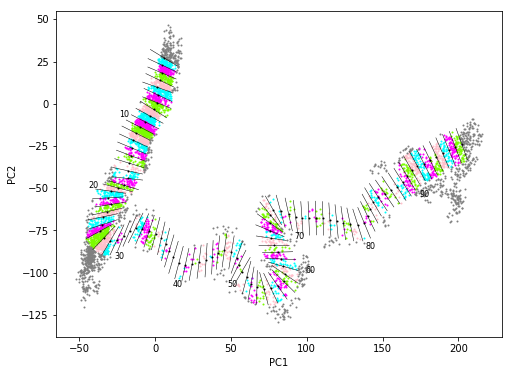

In [12]:
%matplotlib inline
plt.figure(figsize=(8,6))

showid = 0
space = 1

H = list([[] for _ in range(1)])
for k in range(1):
    for i in range(len(X)+1):
        index = np.where(midx==i)
        if k == showid and len(index[0])!=0:
            plt.plot(projections[:,0][index][0:-1:space],
                    projections[:,1][index][0:-1:space],
                    color = color[k][index[0][0]],
                    marker='o', markersize=1,
                    linestyle='None')
    
    # For frames beyond the milestone lines, give gray color
    if True:
        index = np.where(midx==2*len(X))
        H[k].append([-1, index[0].shape[0]])
        if k == showid and len(index[0])!=0:
            plt.plot(projections[:,0][index][0:-1:space],
                    projections[:,1][index][0:-1:space],
                    color = color[k][index[0][0]],
                    marker='o', markersize=1,
                    linestyle='None')
    if k == showid:
        plt.xlabel('PC1')
        plt.ylabel('PC2')

plt.plot(X, Y, color='k', marker='o', markersize=1, linestyle='None')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=8, color='k'))  

plt.show()

## Define the representative cluster for each milestone
For each milestone lines, we collect projected frames from the metadynamics trajectory whose distance in PC1/PC2 to the nearest milestone line is less than cutoff

In [13]:
cutoff = 1 # specify the value of cutoff. Larger cutoff will include points far from the milestone in the representative cluster

T = len(projections)
ntraj = 1
idx = np.array([range(len(fp))]*T)
idx2 = np.array([range(T)]*len(fp)).T
b = Y - slope_opt*X # b of y=m*x+b
trjx = projections[:,0].reshape(len(projections),1)
trjy = projections[:,1].reshape(len(projections),1)
midxT = np.array([midx]*len(fp)).T

# distance between the trajectory to the milestone line
dist = abs(trjy + (trjx*(-slope_opt).T) - b.T)/np.sqrt(1+slope_opt**2).T
index1 = dist < cutoff

# discard trajectory our of the cutoff radius
index2 = midxT != 2*len(fp)

# distance between the trajectory to the path
dist2 = np.sqrt( (trjy-Y.T)**2 + (trjx-X.T)**2 )
index3 = dist2 < (sc)/2

index = np.all([index1,index2,index3],axis=0)
idx_ = idx[index]
idx2_ = idx2[index]

# remove double counted points
idx_new = []
idx2_new = []
for i in range(len(idx2_)):
    if len(idx2_[idx2_==idx2_[i]]) == 1:
        idx2_new.append(idx2_[i])
        idx_new.append(idx_[i])
        
idx_ = np.array(idx_new)
idx2_ = np.array(idx2_new)

In [14]:
# for each milestone, select at most 10 nearest configurations
idx_new = []
idx2_new = []
for i in range(len(fp)):
    tmpid = idx_==i
    if len(idx2_[tmpid])>10:
        rst_proj_sub = np.array([projections[j] for j in idx2_[tmpid]])
        trjx = rst_proj_sub[:,0].reshape(len(rst_proj_sub),1)
        trjy = rst_proj_sub[:,1].reshape(len(rst_proj_sub),1)
        dist = abs(trjy + (trjx*(-slope_opt[i])) - b[i])/np.sqrt(1+slope_opt[i]**2)
        idx2_new.append(idx2_[tmpid][np.argsort(dist,axis=0)][:10,0])
        idx_new.append(idx_[tmpid][np.argsort(dist,axis=0)][:10,0])
    else:
        idx2_new.append(idx2_[tmpid])
        idx_new.append(idx_[tmpid])

idx_ = np.concatenate(idx_new,axis=0)
idx2_ = np.concatenate(idx2_new,axis=0)
idx2_.shape

(726,)

In [16]:
check=list(set(idx_))
idx_fake=[]
idx2_fake=[]
for m in range(len(fp)): 
    if m not in check:
        print("no representative frames at milestone %d, use the frames at milestone %d"%(m,m-1))
        l=len(idx2_[idx_==(m-1)])
        idx_fake.append([m]*l)
        idx2_fake.append(idx2_[idx_==(m-1)])
        
for i,(mid,fid) in enumerate(zip(idx_fake, idx2_fake)):
    idx_ = np.append(idx_, mid)
    idx2_ = np.append(idx2_, fid)

no representative frames at milestone 40, use the frames at milestone 39
no representative frames at milestone 80, use the frames at milestone 79


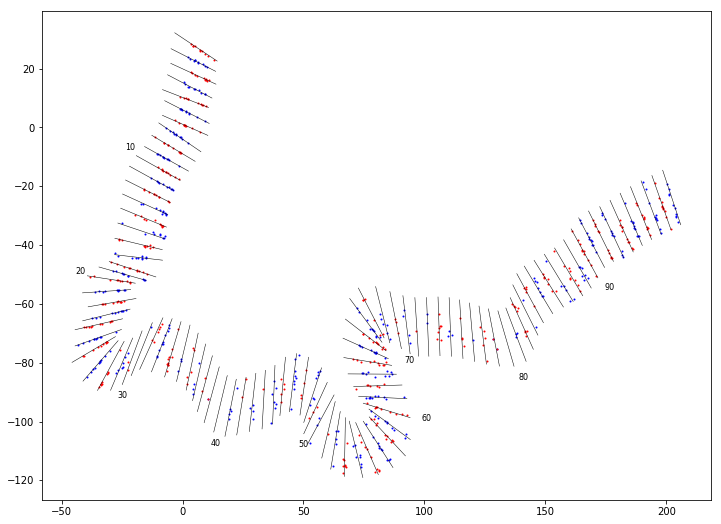

In [17]:
BR=['r','b']

plt.figure(figsize=(12,9))
for i in range(len(idx_)):
    plt.plot(projections[idx2_[i]][0],projections[idx2_[i]][1],
             markersize=1,marker='o',linestyle='None',
            color=BR[int(idx_[i]%2)])

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=8, color='k'))      

plt.show()

## Generate one representative frame of each milestone

In [18]:
repre_path = milestone_path+'/representative_frames_meta'
%mkdir {repre_path}

mkdir: cannot create directory ‘/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory/Milestone_0/representative_frames_meta’: File exists


In [19]:
Repre=[]
check=list(set(idx_))
for m in range(len(fp)):
    x_,y_ = [[],[]]
    for _,i in enumerate(idx2_[idx_==m]):
        x_.append(projections[i,0])
        y_.append(projections[i,1])

    x_, y_ = [np.array(x_),np.array(y_)]
    avx_,avy_ = [x_.mean(),y_.mean()]
    id_ = np.argmin( (x_ - avx_)**2 + (y_ - avy_)**2 )
    Repre.append(idx2_[idx_==m][id_])


Save representative frames as a DCD file

In [20]:
pt.write_traj(repre_path+'/Repre_meta.dcd', traj[Repre], overwrite=True)

## load metadynamics trajectories with waters

In [21]:
watertop = reaction_path+'/water.prmtop'
waterTRAJ = reaction_path+'/_metadyn.dcd'
watertraj = pt.load(waterTRAJ, watertop)

In [22]:
# superpose to 1st frame of the original trajectory
pt.superpose(watertraj, ref=refpdb, mask='(:1-359)&(@N,@C,@CA,@O)')

pytraj.Trajectory, 5455 frames: 
Size: 14.144711 (GB)
<Topology: 116008 atoms, 35846 residues, 35229 mols, PBC with box type = ortho>
           

## Export representative clusters with water

In [23]:
hbond_path = milestone_path+'/H-bonds_meta'
%mkdir {hbond_path}

In [24]:
# export representative clusters into dcd files
pt.save(hbond_path+'/selected_restrt.dcd',watertraj[idx2_],overwrite=True)
np.save(hbond_path+'/selected_frameidx.npy',idx2_)
np.save(hbond_path+'/selected_midx.npy',idx_)